In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kumarajarshi_life_expectancy_who_path = kagglehub.dataset_download('kumarajarshi/life-expectancy-who')

print('Data source import complete.')


100%|██████████| 119k/119k [00:00<00:00, 68.3MB/s]

Extracting files...
Data source import complete.


# Table of Contents
- [Introduction](#Project-Overview)
- [Data Loading](#Load-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Univariate Analysis](#Univariate-Analysis)
  - [Bivariate Analysis](#Bivariate-Analysis)
  - [Multivariate Analysis](#Multivariate-Analysis)
- [Model Implementation](#Model-Implementation)


## Life Expectancy Prediction - Project Overview
<a id="Project-Overview"></a>
### Introduction
Life expectancy is a crucial indicator of a country's overall health and well-being. This project aims to analyze various factors influencing life expectancy across 193 countries using data from 2000 to 2015. The dataset, sourced from the **World Health Organization (WHO)** and **United Nations (UN)**, includes **demographic, economic, and health-related factors** that may impact life expectancy. By leveraging statistical and machine learning models, I aim to identify key predictors affecting life expectancy and provide insights that can help countries improve their healthcare strategies.

### Data Description
The dataset consists of **2938 records** with **22 columns**, categorized as follows:

#### **Demographic Factors**
- **Country:** Name of the country
- **Year:** The year the data was recorded
- **Status:** Indicates whether the country is Developed or Developing

#### **Health Factors**
- **Life expectancy:** Expected number of years a newborn is likely to live *(Target Variable)*
- **Adult Mortality:** Adult mortality rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
- **Infant deaths:** Total number of infant deaths
- **Under-five deaths:** Total number of deaths of children under five
- **Hepatitis B:** Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
- **Measles:** Total number of reported measles cases
- **Polio:** Polio (Pol3) immunization coverage among 1-year-olds (%)
- **Diphtheria:** Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
- **HIV/AIDS:** Deaths per 1000 live births due to HIV/AIDS (ages 0-4 years)
- **BMI:** Average Body Mass Index of the entire population
- **Thinness 1-19 years:** Prevalence of thinness among children and adolescents (ages 1-19 years) (%)
- **Thinness 5-9 years:** Prevalence of thinness among children (ages 5-9 years) (%)

#### **Economic Factors**
- **GDP:** Gross Domestic Product per capita (in USD)
- **Schooling:** Average number of years of schooling (years)
- **Income composition of resources:** Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- **Percentage expenditure:** Health expenditure in absolute terms (possibly dollars per capita) (Note: Incorrectly labeled in the dataset as "percentage of GDP per capita")
- **Total expenditure:** General government expenditure on health as a percentage of total government expenditure (%)

#### **Population and Resources Factors**
- **Population:** Total population of the country

### Project Objectives
This study investigates how different **demographic, economic, and health-related factors** impact life expectancy, with the following key research questions:

1. What are the most significant predictors of life expectancy?
2. How do healthcare expenditures correlate with life expectancy, especially in countries with an average lifespan below 65 years?
3. What is the impact of infant and adult mortality rates on life expectancy?
4. How do lifestyle factors such as alcohol consumption and BMI affect life expectancy?
5. Does increased schooling contribute to higher life expectancy?
6. What role does immunization (Hepatitis B, Polio, Diphtheria) play in improving life expectancy?

By answering these questions, this project aims to provide actionable insights for policymakers to enhance healthcare systems and increase the average lifespan of their populations.

In [53]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import ttest_ind
import math

from scipy.stats import pearsonr , spearmanr
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler ,MinMaxScaler , LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import joblib
import uuid

import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Load Data
<a id="Load-Data"></a>

In [5]:
path = os.path.join(kumarajarshi_life_expectancy_who_path, 'Life Expectancy Data.csv')
data = pd.read_csv(path)

## Displaying a Random Sample of the Data

In [6]:
data.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
841,Equatorial Guinea,2008,Developing,55.400,338.000,3,8.340,1705.679,NaN,436,21.300,4,55.000,2.310,42.000,6.300,22742.382,868418.000,9.300,9.300,0.592,9.100
2372,Solomon Islands,2004,Developing,67.100,29.000,0,1.180,195.526,81.000,0,41.300,0,89.000,5.640,9.000,0.100,818.443,458324.000,1.300,1.300,0.459,8.100
2269,Serbia,2011,Developing,74.600,127.000,1,9.560,915.319,94.000,370,57.700,1,94.000,9.720,94.000,0.100,6423.292,723499.000,2.200,2.200,0.757,13.500
2429,Spain,2011,Developed,82.100,63.000,1,9.620,4873.819,97.000,3802,64.100,2,97.000,9.480,97.000,0.100,31834.218,46742697.000,0.600,0.500,0.867,16.900
1215,Indonesia,2002,Developing,66.700,189.000,177,0.050,43.179,63.000,14492,16.700,222,8.000,2.270,7.000,0.100,899.556,2175859.000,11.000,11.100,0.608,10.600


## Displaying Data Information

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

# Cleans column names

In [8]:
def clean_column_names(df):

  df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
  df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
  df.columns = df.columns.str.lower()  # Convert to lowercase
  return df

data = clean_column_names(data)

## Check Missing Values

In [9]:
data.isnull().sum()

,0
country,0
year,0
status,0
life_expectancy,10
adult_mortality,10
infant_deaths,0
alcohol,194
percentage_expenditure,0
hepatitis_b,553
measles,0


 ### calulate percentage of missing values for each country

In [10]:
# Calculate total missing values per country
missing_per_country = data.groupby("country").apply(lambda x: x.isnull().sum().sum())

# Calculate total possible values per country (rows * columns)
total_values_per_country = data.groupby("country").size() * data.shape[1]

# Compute missing percentage
missing_percentage = (missing_per_country / total_values_per_country) * 100

# Convert to DataFrame and reset index to make 'Country' a column
missing_percentage_data = missing_percentage.reset_index()
missing_percentage_data.columns = ["country", "missing_percentage"]

# Sort by highest missing percentage
missing_percentage_data = missing_percentage_data.sort_values(by="missing_percentage", ascending=False)

missing_percentage_data


,country,missing_percentage
110,Monaco,40.909
146,San Marino,36.364
159,South Sudan,34.659
124,Niue,27.273
38,Cook Islands,27.273
...,...,...
169,Thailand,0.568
187,Vanuatu,0.568
192,Zimbabwe,0.568
1,Albania,0.000


## check if any column for each country has all values missing ```(completely null)```

In [11]:
# Group by "Country" and check for completely null columns
all_null_columns = data.groupby("country").apply(lambda x: x.isnull().all())

fully_missing_columns = {
        country: list(all_null_columns.columns[all_null_columns.loc[country]])
        for country in all_null_columns.index
        if all_null_columns.loc[country].any()
    }

missing_columns_data = pd.DataFrame(list(fully_missing_columns.items()), columns=["country", "fully_missing_columns"])

# Display result
missing_columns_data


,country,fully_missing_columns
0,Antigua and Barbuda,[population]
1,Bahamas,"[gdp, population]"
2,Bahrain,[population]
3,Barbados,[population]
4,Bolivia (Plurinational State of),"[gdp, population]"
5,Brunei Darussalam,[population]
6,Congo,"[gdp, population]"
7,Cook Islands,"[life_expectancy, adult_mortality, gdp, popula..."
8,Cuba,[population]
9,Czechia,"[gdp, population, income_composition_of_resour..."


In [12]:
single_record_countries = data.groupby("country").filter(lambda x: len(x) == 1)["country"].unique()
single_record_countries

array(['Cook Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru',
       'Niue', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu'],
      dtype=object)

In [13]:
data.loc[data['country'].isin(single_record_countries)]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
624,Cook Islands,2013,Developing,NaN,NaN,0,0.010,0.000,98.000,0,82.800,0,98.000,3.580,98.000,0.100,NaN,NaN,0.100,0.100,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.010,11.420,96.000,0,58.400,0,96.000,5.580,96.000,0.100,722.757,NaN,2.700,2.600,0.721,12.700
1650,Marshall Islands,2013,Developing,NaN,NaN,0,0.010,871.878,8.000,0,81.600,0,79.000,17.240,79.000,0.100,3617.752,NaN,0.100,0.100,NaN,0.000
1715,Monaco,2013,Developing,NaN,NaN,0,0.010,0.000,99.000,0,NaN,0,99.000,4.300,99.000,0.100,NaN,NaN,NaN,NaN,NaN,NaN
1812,Nauru,2013,Developing,NaN,NaN,0,0.010,15.607,87.000,0,87.300,0,87.000,4.650,87.000,0.100,136.183,NaN,0.100,0.100,NaN,9.600
1909,Niue,2013,Developing,NaN,NaN,0,0.010,0.000,99.000,0,77.300,0,99.000,7.200,99.000,0.100,NaN,NaN,0.100,0.100,NaN,NaN
1958,Palau,2013,Developing,NaN,NaN,0,NaN,344.691,99.000,0,83.300,0,99.000,9.270,99.000,0.100,1932.122,292.000,0.100,0.100,0.779,14.200
2167,Saint Kitts and Nevis,2013,Developing,NaN,NaN,0,8.540,0.000,97.000,0,5.200,0,96.000,6.140,96.000,0.100,NaN,NaN,3.700,3.600,0.749,13.400
2216,San Marino,2013,Developing,NaN,NaN,0,0.010,0.000,69.000,0,NaN,0,69.000,6.500,69.000,0.100,NaN,NaN,NaN,NaN,NaN,15.100
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.010,78.281,9.000,0,79.300,0,9.000,16.610,9.000,0.100,3542.136,1819.000,0.200,0.100,NaN,0.000


Some countries have only one recorded entry, and their ```Life Expectancy``` value is missing. Since there is no way to accurately estimate or fill in the missing value for these cases, we have decided to remove these records from the dataset to maintain data reliability.

In [14]:
data = data.loc[~data['country'].isin(single_record_countries)]

Fill missing values in numerical columns
- using the median value for each country.

In [15]:
data["life_expectancy"] = data.groupby("country")["life_expectancy"].transform(lambda x: x.fillna(x.median()))
data["adult_mortality"] = data.groupby("country")["adult_mortality"].transform(lambda x: x.fillna(x.median()))
data["bmi"] = data.groupby("country")["bmi"].transform(lambda x: x.fillna(x.median()))

## Columns to be imputed using the mode:

- Polio (19 missing values)
- Diphtheria (19 missing values)
- Hepatitis B (553 missing values).

```Rationale```: Impute missing values with the mode for each country, as immunization rates are often stable for several years.

In [16]:
for col in ["polio", "diphtheria", "hepatitis_b"]:
    data[col] = data.groupby("country")[col].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

#### Imputing missing values in specific columns using linear interpolation within each country.

### Columns to be imputed:
- gdp
- population
- alcohol
- total_expenditure

#### Rationale:
-  These variables are likely to exhibit trends over time within a specific country. Linear interpolation is a suitable method to estimate missing values based on the observed values in the preceding and succeeding years within the same country.

In [18]:
for col in ["gdp", "population", "alcohol", "total_expenditure"]:
    data[col] = data.groupby("country")[col].transform(lambda x: x.interpolate(method='linear'))

In [19]:
data.isnull().sum()

,0
country,0
year,0
status,0
life_expectancy,0
adult_mortality,0
infant_deaths,0
alcohol,192
percentage_expenditure,0
hepatitis_b,144
measles,0


In [20]:
data.dropna(inplace=True)

In [21]:
data.country.nunique()

133

# Exploratory Data Analysis
<a id="Exploratory-Data-Anasysis"></a>

## Univariate Analysis
<a id="Univariate-Analysis"></a>

In [22]:
data.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000,1987.000
mean,2006.985,67.982,175.187,36.624,4.456,685.492,76.785,2729.562,36.429,50.933,80.637,5.903,80.712,2.275,5392.336,13583902.495,5.130,5.199,0.603,11.639
std,4.323,9.706,131.617,138.785,3.977,1761.669,27.481,12102.389,19.736,188.933,24.027,2.287,24.142,6.005,11480.810,64901129.051,4.750,4.844,0.206,3.213
min,2000.000,36.300,1.000,0.000,0.010,0.000,2.000,0.000,1.400,0.000,3.000,0.370,2.000,0.100,1.681,34.000,0.100,0.100,0.000,0.000
25%,2003.000,61.700,75.000,1.000,0.830,29.470,71.000,0.000,18.150,1.000,75.000,4.360,76.000,0.100,384.553,196748.000,1.600,1.600,0.473,9.700
50%,2007.000,69.900,153.000,4.000,3.770,104.314,88.000,20.000,38.700,4.000,91.000,5.800,91.000,0.100,1334.652,1396861.000,3.300,3.400,0.648,11.900
75%,2011.000,74.700,243.000,25.000,7.190,470.870,95.000,499.500,55.000,36.000,96.000,7.385,96.000,1.400,4441.531,7625918.500,7.600,7.700,0.745,13.700
max,2015.000,89.000,723.000,1800.000,17.870,18961.349,99.000,212183.000,77.100,2500.000,99.000,14.390,99.000,50.600,119172.742,1293859294.000,27.700,28.600,0.936,20.700


In [23]:
def plot_distributions(data):
    # Remove infinite values and drop missing data
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    num_columns = data.select_dtypes(include=['number']).columns.tolist()
    num_features = len(num_columns)


    cols = min(4, num_features)
    rows = math.ceil(num_features / cols)


    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = np.array(axes).flatten()

    for i, column in enumerate(num_columns):
        ax = axes[i]
        sns.histplot(data[column], kde=True, ax=ax, color='teal', bins=30)

        # Calculate mean and median
        mean_value = data[column].mean()
        median_value = data[column].median()

        # Add vertical lines for mean and median
        ax.axvline(mean_value, color='firebrick', linestyle='--', label=f'Mean: {mean_value:.2f}')
        ax.axvline(median_value, color='darkgreen', linestyle='-', label=f'Median: {median_value:.2f}')

        # Set plot title and labels
        ax.set_title(f'Distribution of {column}', fontsize=12)
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.legend()

    # Remove unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


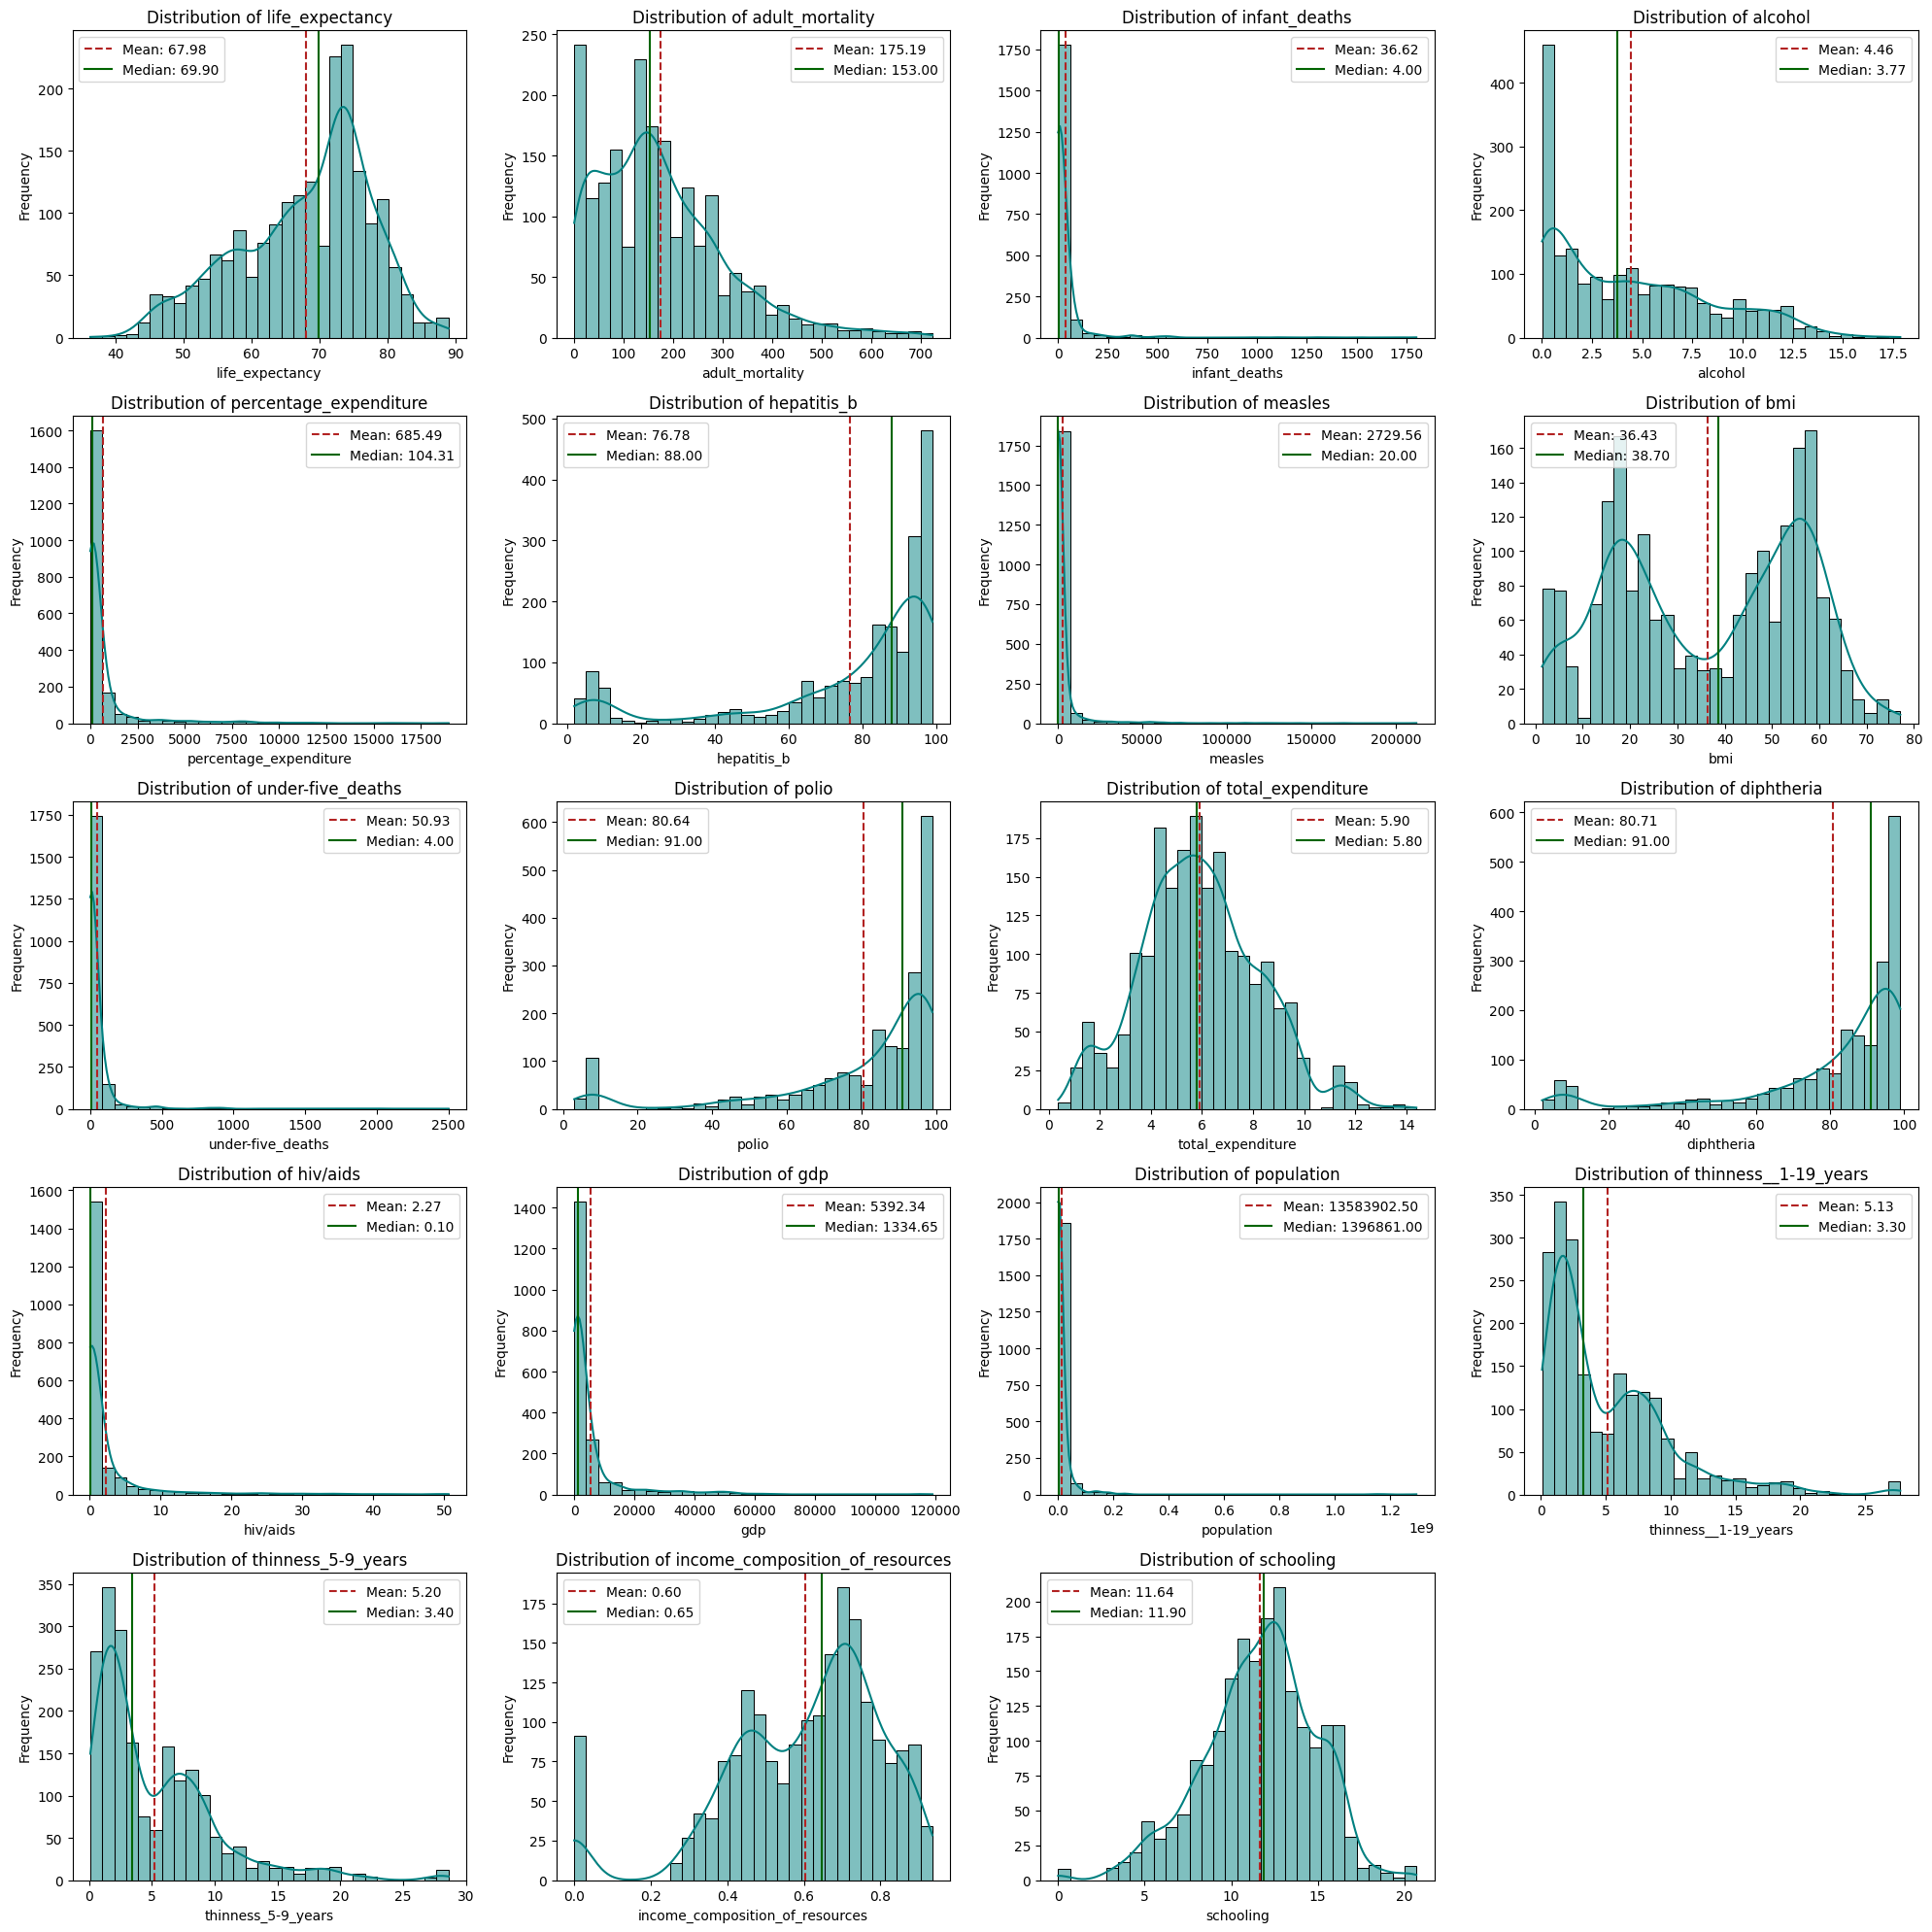

In [24]:
plot_distributions(data.drop('year', axis = 1))



# A Global Portrait: Health, Wealth, and Education in the Modern Era

In the intricate tapestry of global societies, a vivid narrative emerges from the data, weaving together the threads of human longevity, health, economic vitality, and educational attainment. This story, grounded in averages and ranges, paints a picture of resilience and disparity, where progress and challenges coexist across nations.

## The Pulse of Life: Longevity and Mortality

Across the globe, the average person can expect to live to **68 years**, a testament to advancements in healthcare and living standards. Yet, this figure masks a stark divide: some individuals, blessed by fortune or circumstance, reach the venerable age of **89**, while others, burdened by systemic challenges, barely surpass **36**. The fragility of life is further underscored by **adult mortality rates**, which claim **175 out of every 1,000 adults** annually. In some regions, this rate plummets to a mere **1 death per 1,000**, reflecting robust healthcare systems, while in others, it soars to **723**, signaling dire conditions. For the youngest, **infant mortality** remains a pressing concern, with an average of **36 infant deaths per country**, though some nations grapple with up to **1,800** losses, a haunting reminder of uneven progress.

## The Battle for Health: Disease and Prevention

The fight against disease reveals both triumphs and ongoing struggles. Immunization efforts have made significant strides, with **77%** of people receiving the Hepatitis B vaccine and **81%** protected against Polio and Diphtheria. Yet, diseases like **measles** persist, affecting an average of **2,730 people per country**, with some regions reporting cases in the hundreds of thousands. Malnutrition, too, leaves its mark, with **5% of children** aged 1-19 and 5-9 years classified as thin, a subtle but critical indicator of resource scarcity.

## Lifestyle and Investment: Balancing Indulgence and Care

Cultural habits shape health outcomes, as seen in **alcohol consumption**, which averages **4.46 liters per person per year** globally. In some communities, this figure climbs to **17.5 liters**, reflecting diverse social norms. To support well-being, nations allocate an average of **685 units** (likely dollars) per capita to health expenditure, though some invest as much as **18,961**, highlighting vast disparities in healthcare access.

## The Economic Backbone: Wealth and Resources

Economic vitality underpins these health and social outcomes. The average **GDP per capita** stands at **5,392 USD**, but the range is wide, with some nations thriving and others languishing in poverty. The **income composition**, scored at an average of **0.60** on a 0-to-1 scale, reflects varying levels of resource distribution, shaping opportunities for millions. Populations, averaging **13.58 million** per nation, range from small communities of thousands to sprawling countries exceeding a billion, each navigating unique economic landscapes.

## The Pursuit of Knowledge: Education as a Foundation

Education, a cornerstone of progress, sees individuals spending an average of **12 years** in school. Yet, this figure spans from a mere **1 year** in some regions to an impressive **20 years** in others, illustrating the spectrum of access to learning. This pursuit of knowledge fuels innovation and resilience, shaping the future of societies worldwide.

## A World in Balance

This global narrative, drawn from precise metrics, reveals a world of contrasts—where longevity and loss, health and disease, wealth and want, and knowledge and limitation coexist. It is a story of humanity's shared journey, marked by achievements and tempered by challenges, as nations strive to elevate the quality of life for all.



### Let's handle outliers

In [25]:
def winsorize(data, column, lower_percentile=0.05, upper_percentile=0.95):
    lower_limit = data[column].quantile(lower_percentile)
    upper_limit = data[column].quantile(upper_percentile)
    data[column] = np.clip(data[column], lower_limit, upper_limit)
    return data

# Select numerical columns
numerical_cols = data.drop('year', axis = 1).select_dtypes(include=np.number).columns

# Apply Winsorization to each numerical column
for col in numerical_cols:
    data = winsorize(data, col)

### Categorical Columns

In [26]:
data[['year' , 'status']].astype('category').describe()

,year,status
count,1987,1987
unique,16,2
top,2000,Developing
freq,133,1702


In [27]:
status_counts = data['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']
status_counts

,status,count
0,Developing,1702
1,Developed,285


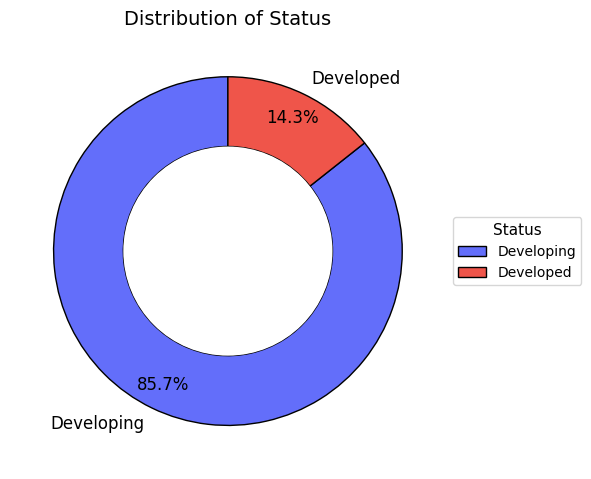

In [29]:
sizes = status_counts['count']
colors = ['#636EFA', '#EF554A']
labels = status_counts['status']
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='black'),
    autopct='%1.1f%%',
    pctdistance=0.85,
    textprops={'fontsize': 12}
)

centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title('Distribution of Status', fontsize=14)
ax.legend(wedges, labels, title="Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10, title_fontsize=11)

# Improve layout
plt.tight_layout()
plt.show()

Predominance of Developing Countries:

- Count: 1702

- Percentage: 85.7%

- Insight: `Most` countries are still developing.

<hr>

Smaller Proportion of Developed Countries:

- Count: 285

- Percentage: 14.3%

- Insight: `Fewer` countries are developed.

In summary, the data reveals that the majority of countries are `developing`, with substantial opportunities for growth and improvement through targeted policies and international collaboration.

## Bivariate Analysis
<a id="Bivariate-Analysis"></a>

### How does healthcare expenditure impact life expectancy?

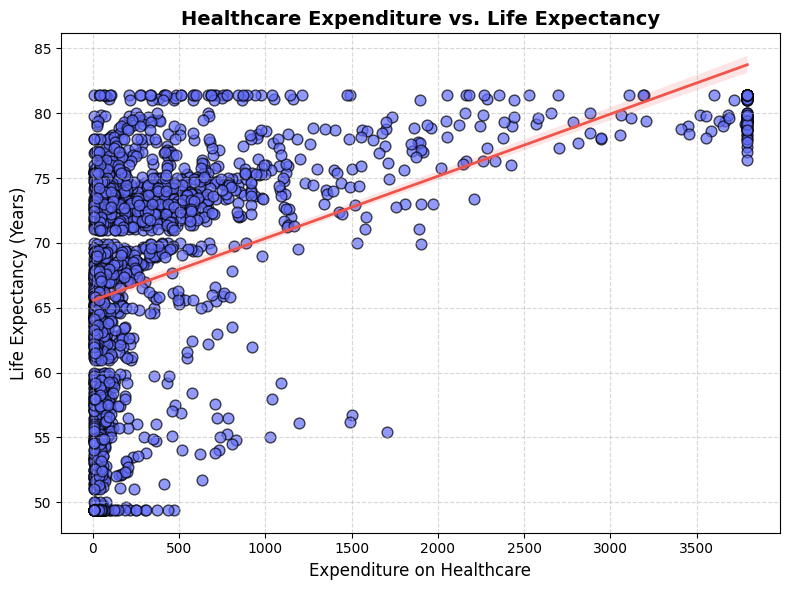

In [32]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=data,
    x="percentage_expenditure",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#636EFA', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#EF554A', 'linewidth': 2},
)

plt.title("Healthcare Expenditure vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Expenditure on Healthcare", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [33]:
correlation, p_value = spearmanr(
    data["percentage_expenditure"], data["life_expectancy"]
)
print(f"Spearman correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.6013431118989135
P-value: 1.04481315360701e-195


Correlation:
- The value of 0.6013 suggests that, generally, as the healthcare expenditure increases, life expectancy also tends to increase.

P-value:
- The p-value is extremely small (1.04481315360701e-195), which is much less than the typical alpha level of 0.05. This implies that the correlation you’ve found is statistically significant, meaning there’s a very low probability that this correlation is due to random chance.

### What is the relationship between mortality rates (infant/adult) and life expectancy?

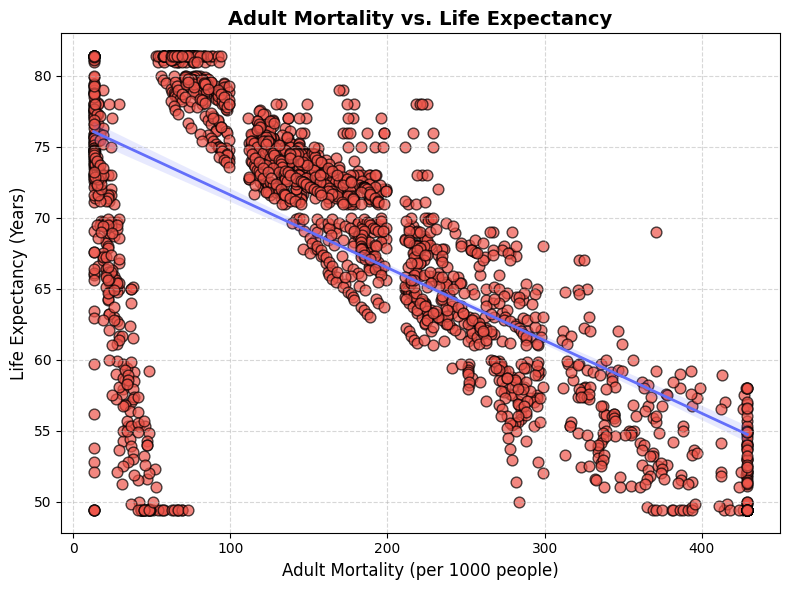

In [34]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=data,
    x="adult_mortality",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#EF554A', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#636EFA', 'linewidth': 2},
)

plt.title("Adult Mortality vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Adult Mortality (per 1000 people)", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [35]:
correlation_adult_mortality, p_value_adult_mortality = spearmanr(
    data["adult_mortality"], data["life_expectancy"]
)
print(f"Spearman correlation (Adult Mortality): {correlation_adult_mortality}")
print(f"P-value (Adult Mortality): {p_value_adult_mortality}")

Spearman correlation (Adult Mortality): -0.6177237464733062
P-value (Adult Mortality): 2.0366964205991307e-209


- Correlation: The negative value of `-0.6177` suggests a moderately strong negative correlation. This means that as adult mortality rates increase, life expectancy tends to decrease.

- P-value: The very small `p-value`indicates that this `negative correlation` is statistically significant, meaning it’s unlikely to have occurred by random chance.

Overall, this highlights the significant impact of adult mortality on life expectancy. The negative correlation and high statistical significance underscore the importance of addressing factors contributing to adult mortality to improve life expectancy.

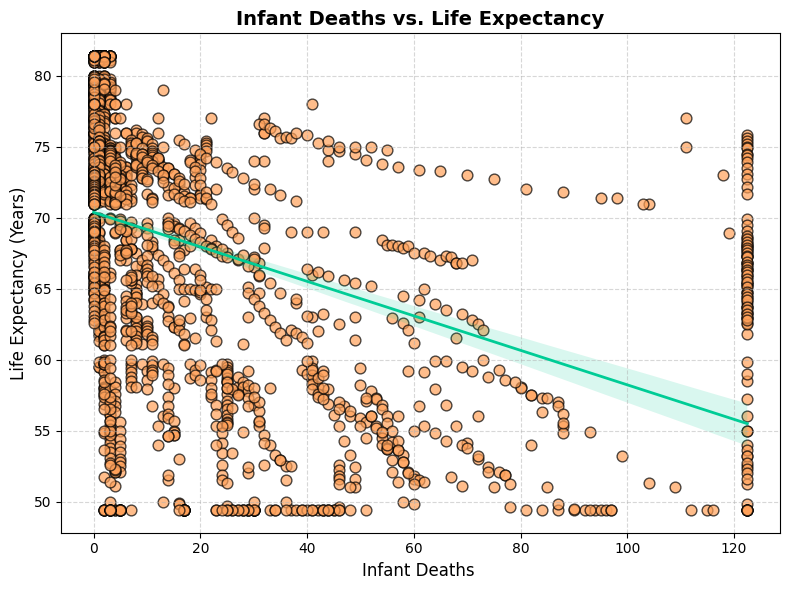

In [36]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=data,
    x="infant_deaths",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#FFA15A', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#00CC96', 'linewidth': 2},
)


plt.title("Infant Deaths vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Infant Deaths ", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [37]:
correlation_infant_deaths, p_value_infant_deaths = spearmanr(
    data["infant_deaths"], data["life_expectancy"]
)
print(f"Spearman correlation (Infant Deaths): {correlation_infant_deaths}")
print(f"P-value (Infant Deaths): {p_value_infant_deaths}")

Spearman correlation (Infant Deaths): -0.5701838619023767
P-value (Infant Deaths): 1.0245085393430064e-171


- Correlation: The negative value of -0.5702 suggests a moderate negative correlation, meaning that as the number of infant deaths increases, life expectancy tends to decrease.

- P-value: The extremely small p-value indicates that this negative correlation is statistically significant, meaning it’s highly unlikely to have occurred by random chance.

Overall, this indicates the significant impact of infant mortality on life expectancy, with the negative correlation emphasizing the importance of addressing factors contributing to infant deaths to improve life expectancy.

### Does GDP correlate positively with life expectancy?

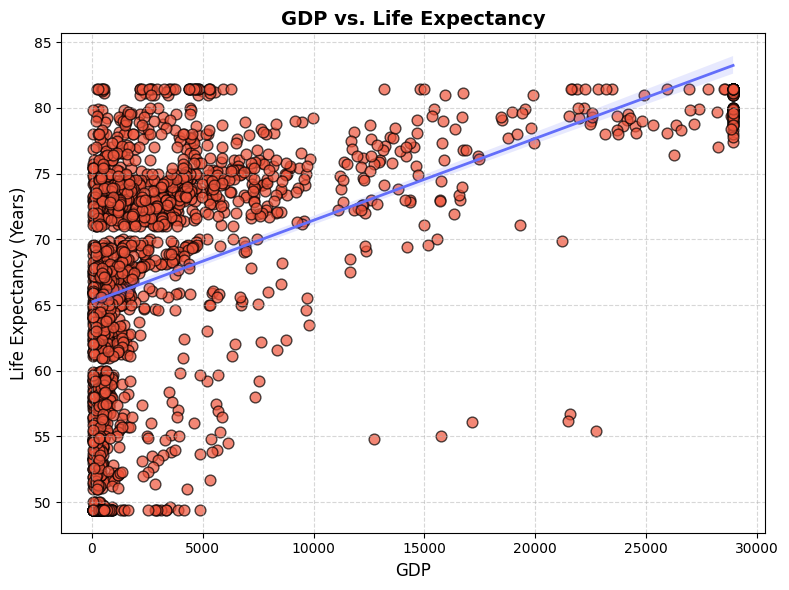

In [38]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=data,
    x="gdp",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#EF553B', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#636EFA', 'linewidth': 2},
)

plt.title("GDP vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("GDP", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [39]:
correlation, p_value = spearmanr(data["gdp"], data["life_expectancy"])
print(f"Spearman correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.6031355572113055
P-value: 3.6103735038944555e-197


Key insights:
- Moderate Positive Correlation: The Spearman correlation coefficient is approximately 0.6031, indicating a moderately strong positive relationship. As GDP increases, life expectancy also tends to increase.

- Statistical Significance: The extremely small p-value (3.610373508944555e-197) suggests that this correlation is statistically significant, meaning it’s unlikely to have occurred by random chance.

- Higher GDP often translates to better access to healthcare, nutrition, and overall living conditions, leading to longer life expectancy.

In summary, the analysis underscores the importance of economic prosperity for improving public health outcomes.

### How does alcohol consumption affect life expectancy?

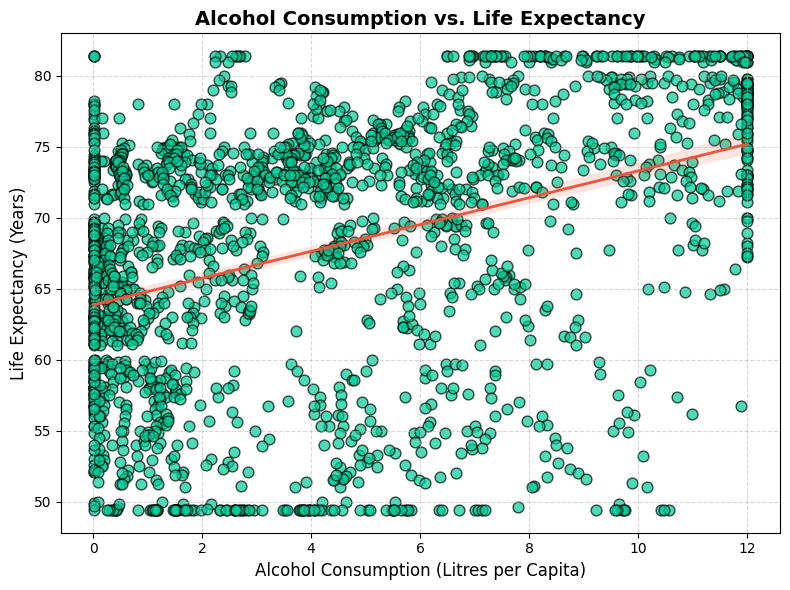

In [40]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=data,
    x="alcohol",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#00CC96', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#EF553B', 'linewidth': 2},
)

plt.title("Alcohol Consumption vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Alcohol Consumption (Litres per Capita)", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Data Distribution:
- The data points are `scattered` but generally follow the upward trend, reinforcing the positive correlation.

### Does higher schooling improve life expectancy?

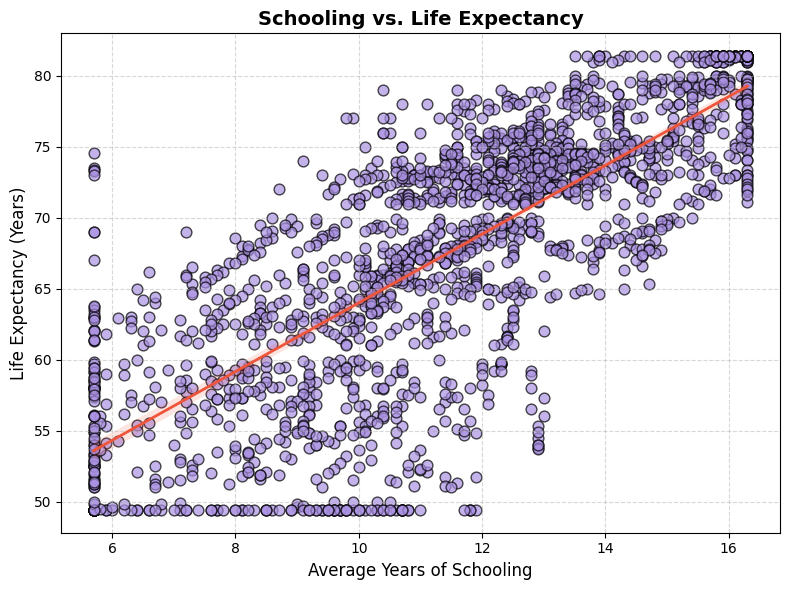

In [41]:
plt.figure(figsize=(8, 6))

sns.regplot(
    data=data,
    x="schooling",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#AB92E3', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#EF553B', 'linewidth': 2},
)

plt.title("Schooling vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Average Years of Schooling", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [42]:
correlation, p_value = spearmanr(data["schooling"], data["life_expectancy"])
print(f"Spearman correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.8037452583777143
P-value: 0.0


Brief Insight:
- Strong Positive Correlation: The scatter plot shows that more years of schooling are associated with higher life expectancy.

- Statistical Significance: The Spearman correlation coefficient is 0.8037, with a p-value of 0.0, indicating a strong and statistically significant relationship.

In summary, higher education levels are linked to longer life expectancy.



### What is the effect of immunization coverage on life expectancy?

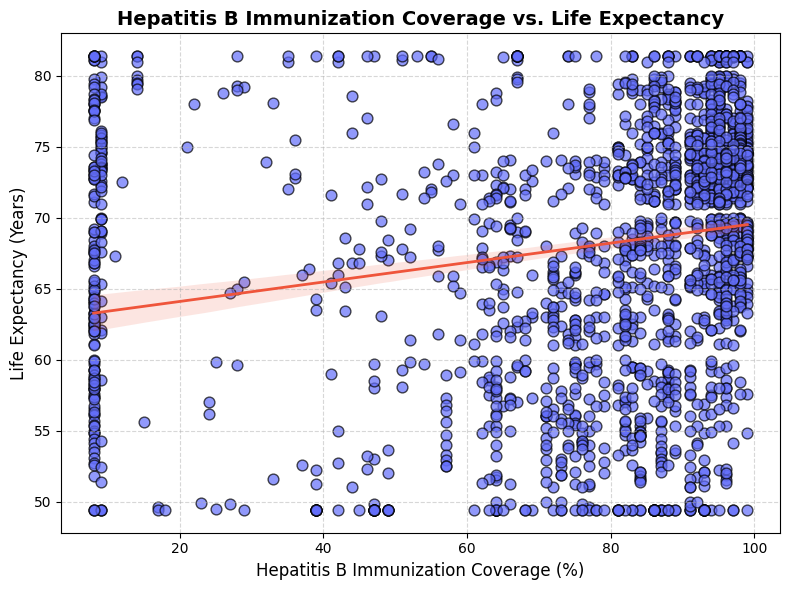

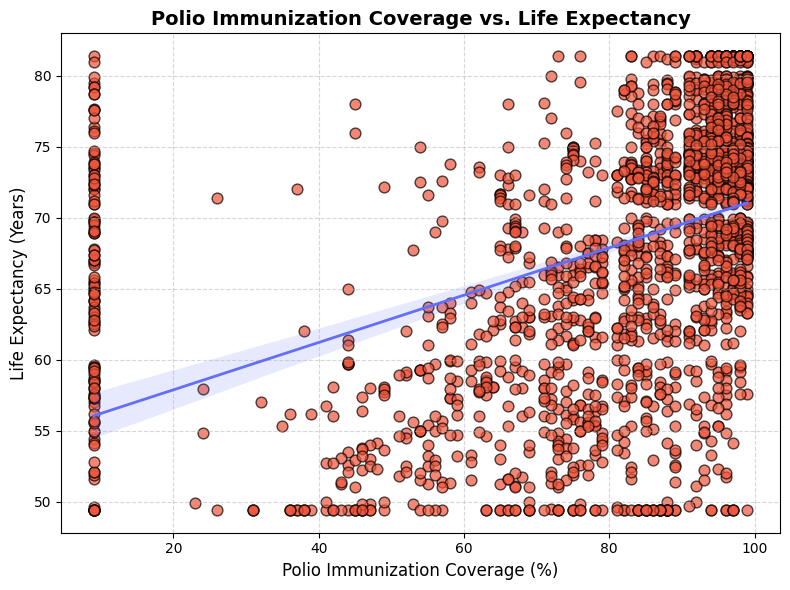

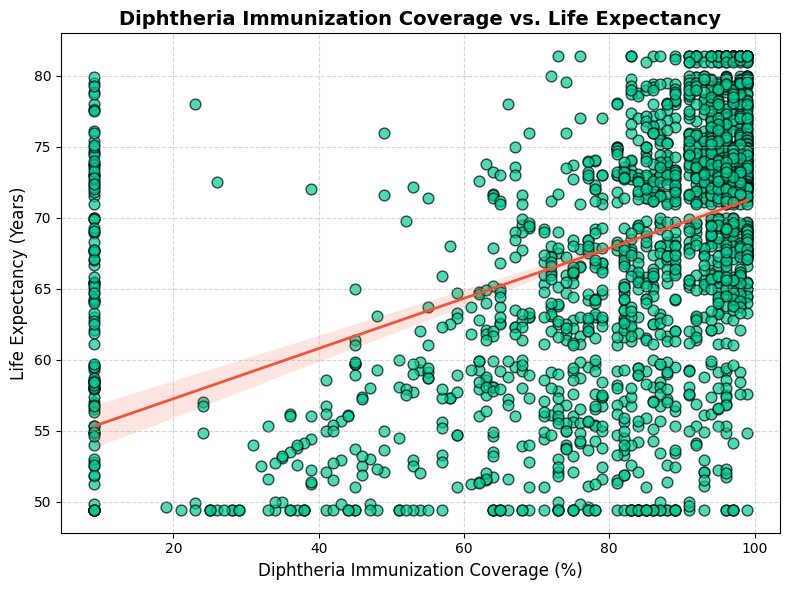

In [43]:
plt.figure(figsize=(8, 6))
sns.regplot(
    data=data,
    x="hepatitis_b",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#636EFA', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#EF553B', 'linewidth': 2},
)

plt.title("Hepatitis B Immunization Coverage vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Hepatitis B Immunization Coverage (%)", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(
    data=data,
    x="polio",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#EF553B', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#636EFA', 'linewidth': 2},
)

plt.title("Polio Immunization Coverage vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Polio Immunization Coverage (%)", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.regplot(
    data=data,
    x="diphtheria",
    y="life_expectancy",
    scatter_kws={'s': 60, 'color': '#00CC96', 'alpha': 0.7, 'edgecolor': 'black'},
    line_kws={'color': '#EF553B', 'linewidth': 2},
)

plt.title("Diphtheria Immunization Coverage vs. Life Expectancy", fontsize=14, weight='bold')
plt.xlabel("Diphtheria Immunization Coverage (%)", fontsize=12)
plt.ylabel("Life Expectancy (Years)", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [44]:
# Hepatitis B
correlation_hepatitis_b, p_value_hepatitis_b = spearmanr(
    data["hepatitis_b"], data["life_expectancy"]
)
print(f"Spearman correlation (Hepatitis B): {correlation_hepatitis_b}")
print(f"P-value (Hepatitis B): {p_value_hepatitis_b}")

# Polio
correlation_polio, p_value_polio = spearmanr(data["polio"], data["life_expectancy"])
print(f"Spearman correlation (Polio): {correlation_polio}")
print(f"P-value (Polio): {p_value_polio}")

# Diphtheria
correlation_diphtheria, p_value_diphtheria = spearmanr(
    data["diphtheria"], data["life_expectancy"]
)
print(f"Spearman correlation (Diphtheria): {correlation_diphtheria}")
print(f"P-value (Diphtheria): {p_value_diphtheria}")

Spearman correlation (Hepatitis B): 0.3241734194622333
P-value (Hepatitis B): 7.623766559834287e-50
Spearman correlation (Polio): 0.5315106102101115
P-value (Polio): 2.679544816623509e-145
Spearman correlation (Diphtheria): 0.5448719290857702
P-value (Diphtheria): 4.89331342840797e-154


### Effect of Immunization Coverage on Life Expectancy

1. **Hepatitis B:**
   - **Correlation Coefficient:** 0.3242
   - **P-value:** 7.6238e-50
   - **Insight:** There's a weak positive correlation between Hepatitis B immunization coverage and life expectancy. The relationship is statistically significant.

2. **Polio:**
   - **Correlation Coefficient:** 0.5315
   - **P-value:** 2.6795e-145
   - **Insight:** There's a moderate positive correlation between Polio immunization coverage and life expectancy. The relationship is statistically significant.

3. **Diphtheria:**
   - **Correlation Coefficient:** 0.5449
   - **P-value:** 4.8933e-154
   - **Insight:** There's a moderate positive correlation between Diphtheria immunization coverage and life expectancy. The relationship is statistically significant.

### Conclusion:
Higher immunization coverage for Hepatitis B, Polio, and Diphtheria is associated with higher life expectancy. The statistical significance of these correlations underscores the importance of immunization programs in improving public health and increasing life expectancy.

### let's explore the relationship between status and Life Expectancy.

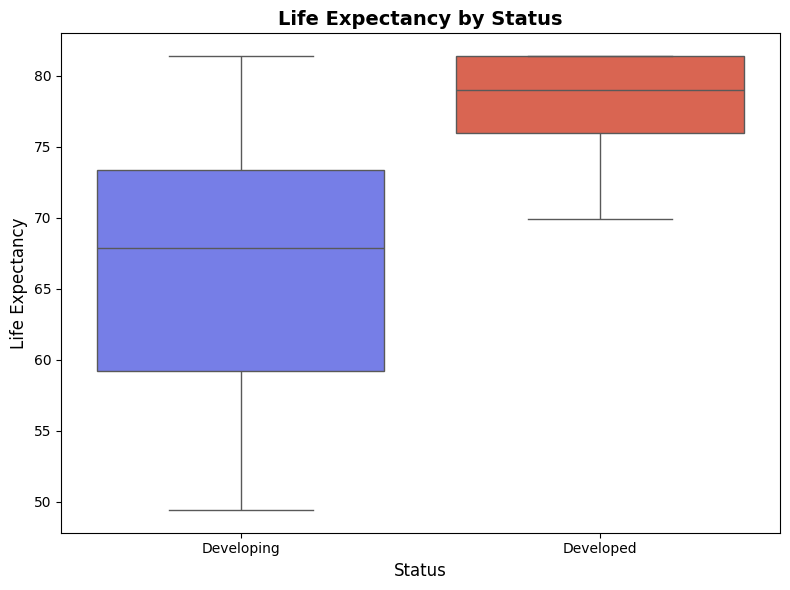

In [45]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    data=data,
    x="status",
    y="life_expectancy",
    palette=["#636EFA", "#EF553B"]
)

plt.title("Life Expectancy by Status", fontsize=14, weight='bold')
plt.xlabel("Status", fontsize=12)
plt.ylabel("Life Expectancy", fontsize=12)

plt.tight_layout()
plt.show()

In [46]:
developed_data = data[data["status"] == "Developed"]["life_expectancy"]
developing_data = data[data["status"] == "Developing"]["life_expectancy"]

t_statistic, p_value = ttest_ind(developed_data, developing_data)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 22.728601130239195
P-value: 7.80943605086225e-102


### Conclusion from the Box Plot and T-test Results

The box plot and t-test results collectively provide insights into life expectancy differences between developed and developing countries:

#### From the Box Plot:
- **Higher Life Expectancy in Developed Countries:** The median life expectancy for developed countries is around 75 years, while for developing countries, it is around 65 years.
- **Variability:** Developing countries show more variability in life expectancy compared to developed countries.

#### From the T-test Results:
- **T-statistic:** 22.7286
- **P-value:** 7.8094e-102

#### Interpretation:
- The extremely high t-statistic and the very small p-value indicate that the difference in life expectancy between developed and developing countries is statistically significant. This means that the observed difference is unlikely to have occurred by random chance.
  
### Overall Conclusion:
Developed countries generally have a higher life expectancy compared to developing countries, and this difference is statistically significant. This highlights the importance of factors such as healthcare, economic stability, and living conditions that contribute to higher life expectancy in developed nations.

<hr>

## Multivariate Analysis
<a id="Multivariate-Analysis"></a>

### Does better schooling combined with healthcare spending improve life expectancy?

In [67]:
fig = px.scatter(
    data_frame=data,
    x="schooling",
    y="percentage_expenditure",
    size="population",
    title="Schooling, Healthcare Spending, and Life Expectancy",
    hover_name="country",
    size_max=60,
    color_continuous_scale="Viridis",
)

fig.show()

- The visualization highlights a **positive correlation** between schooling years, healthcare expenditure, and life expectancy.  
- **Higher education levels** are associated with increased healthcare spending, leading to improved life expectancy.  
- The **color gradient** reinforces this trend, showing that countries investing more in education and healthcare tend to have better health outcomes.  
- **Population size variations** indicate diverse investment patterns, influenced by economic and demographic factors.

### Does higher GDP and healthcare expenditure together lead to longer life expectancy?

In [48]:
selected_data = data[["gdp", "percentage_expenditure", "life_expectancy"]]

# Calculate correlation matrix
correlation_matrix = selected_data.corr()

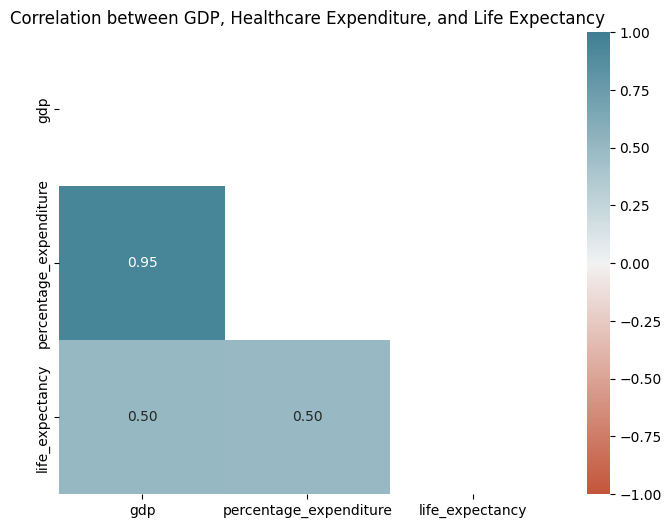

In [49]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    vmin=-1,
    vmax=1,
    cmap=sns.diverging_palette(20, 220, as_cmap=True),
    annot=True,
    fmt=".2f",
    mask=mask,
)

plt.title("Correlation between GDP, Healthcare Expenditure, and Life Expectancy")
plt.show()

- There is a strong positive correlation (0.95) between GDP and healthcare expenditure, indicating that higher GDP countries allocate more funds to healthcare.
- Life expectancy has a moderate positive correlation (0.50) with both GDP and healthcare expenditure, suggesting that economic growth and healthcare investment contribute to longer life expectancy.

# Model Implementation
<a id="Model-Implementation"></a>

## Data Preparation
<a id="Data-Preparation"></a>

### let's encode the `status` column

In [50]:
label_encoder = LabelEncoder()
data['status'] = label_encoder.fit_transform(data['status'])

In [65]:
# save processed data
data.to_csv('processed_data.csv', index=False)

### Separate features and target

In [64]:
data.drop(columns=['country','life_expectancy', 'year']).columns

Index(['status', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness__1-19_years', 'thinness_5-9_years', 'income_composition_of_resources', 'schooling'], dtype='object')

In [51]:
X = data.drop(columns=['country','life_expectancy', 'year']).values
y = data['life_expectancy'].values

## A class to manage the entire machine learning pipeline

In [58]:
class ModelTrainingPipeline:
    """A class to manage the entire machine learning pipeline for regression tasks."""

    def __init__(self, random_state=42):
        """Initialize the pipeline with a random state for reproducibility."""
        self.random_state = random_state
        self.models = self._define_models()
        self.param_grid = self._define_param_grid()
        self.results = []
        self.best_model = None
        self.best_val_mae = float('inf')
        self.best_model_name = None
        self.results_df = None
        self.y_test = None
        self.y_test_pred = None

    def _define_models(self):
        """Define the models and their respective scalers (if needed)."""
        return {
            "LinearRegression": (LinearRegression(), StandardScaler()),
            "Ridge": (Ridge(), StandardScaler()),
            "Lasso": (Lasso(), StandardScaler()),
            "SVR": (SVR(kernel='rbf'), StandardScaler()),
            "KNN": (KNeighborsRegressor(), StandardScaler()),
            "DecisionTree": (DecisionTreeRegressor(), None),  # No scaler for tree-based
            "RandomForest": (RandomForestRegressor(), None),  # No scaler
            "GradientBoosting": (GradientBoostingRegressor(), None),  # No scaler
            "XGBoost": (XGBRegressor(), None),  # No scaler
            "LightGBM": (LGBMRegressor(verbose=-1), None),  # No scaler
            "CatBoost": (CatBoostRegressor(verbose=0), None)  # No scaler
        }

    def _define_param_grid(self):
        """Define hyperparameter grids for grid search."""
        return {
            "LinearRegression": {},
            "Ridge": {'model__alpha': [0.01, 0.1, 1, 10, 100]},
            "Lasso": {'model__alpha': [0.001, 0.01, 0.1, 1, 10]},
            "SVR": {
                'model__C': [0.1, 1, 10, 100],
                'model__epsilon': [0.01, 0.1, 0.2],
                'model__gamma': ['scale', 'auto', 0.1, 1]
            },
            "KNN": {
                'model__n_neighbors': [3, 5, 7, 10],
                'model__p': [1, 2],
                'model__weights': ['uniform', 'distance']
            },
            "DecisionTree": {
                'model__max_depth': [None, 5, 10, 20],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            },
            "RandomForest": {
                'model__n_estimators': [50, 100, 200],
                'model__max_depth': [None, 5, 10],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 4]
            },
            "GradientBoosting": {
                'model__n_estimators': [50, 100, 200],
                'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                'model__max_depth': [3, 5, 7],
                'model__subsample': [0.8, 1.0]
            },
            "XGBoost": {
                'model__n_estimators': [50, 100, 200],
                'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                'model__max_depth': [3, 5, 7],
                'model__subsample': [0.8, 1.0],
                'model__colsample_bytree': [0.8, 1.0]
            },
            "LightGBM": {
                'model__n_estimators': [50, 100, 200],
                'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                'model__max_depth': [3, 5, 7],
                'model__num_leaves': [31, 50, 100]
            },
            "CatBoost": {
                'model__iterations': [50, 100, 200],
                'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                'model__depth': [4, 6, 8],
                'model__l2_leaf_reg': [1, 3, 5]
            }
        }

    def split_data(self, X, y, train_size=0.7, val_size=0.15, test_size=0.15):
        """Split data into train, validation, and test sets."""
        assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split sizes must sum to 1."

        # First split: Train + Validation vs Test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )

        # Second split: Train vs Validation
        val_proportion = val_size / (train_size + val_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_proportion, random_state=self.random_state
        )

        return X_train, X_val, X_test, y_train, y_val, y_test

    def train_and_evaluate(self, X, y):
        """Train models, select best model based on validation set, then evaluate on test set."""
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

        # Train and evaluate on validation set
        for name, (model, scaler) in self.models.items():
            print(f"Training {name}...")

            # Create pipeline (skip scaler for tree-based models)
            steps = [('model', model)]
            if scaler is not None:
                steps.insert(0, ('scaler', scaler))
            pipeline = Pipeline(steps)

            # Grid search on training set with cross-validation
            grid_search = GridSearchCV(
                pipeline,
                self.param_grid[name],
                cv=5,
                scoring='neg_mean_absolute_error',
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)

            # Best model evaluation on validation set
            best_model = grid_search.best_estimator_
            y_val_pred = best_model.predict(X_val)

            # Compute validation metrics
            val_mae = mean_absolute_error(y_val, y_val_pred)
            val_mse = mean_squared_error(y_val, y_val_pred)
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(y_val, y_val_pred)

            # Store validation results
            self.results.append({
                "Model": name,
                "Best Params": grid_search.best_params_,
                "Val MAE": val_mae,
                "Val MSE": val_mse,
                "Val RMSE": val_rmse,
                "Val R²": val_r2,
                "Test MAE": None,  # Placeholder for test metrics
                "Test MSE": None,
                "Test RMSE": None,
                "Test R²": None
            })

            # Update best model based on Validation MAE
            if val_mae < self.best_val_mae:
                self.best_val_mae = val_mae
                self.best_model = best_model
                self.best_model_name = name

        # Evaluate best model on test set after selection
        if self.best_model is not None:
            print(f"Evaluating best model ({self.best_model_name}) on test set...")
            y_test_pred = self.best_model.predict(X_test)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            test_rmse = np.sqrt(test_mse)
            test_r2 = r2_score(y_test, y_test_pred)

            # Update results with test metrics for best model
            for result in self.results:
                if result["Model"] == self.best_model_name:
                    result.update({
                        "Test MAE": test_mae,
                        "Test MSE": test_mse,
                        "Test RMSE": test_rmse,
                        "Test R²": test_r2
                    })

            # Store test set data for visualization
            self.y_test = y_test
            self.y_test_pred = y_test_pred

        # Create results DataFrame
        self.results_df = pd.DataFrame(self.results)

    def visualize_results(self):
        """Visualize model performance (Val R²) and predicted vs ground truth for best model on test set."""
        if self.results_df is None:
            raise ValueError("No results to visualize. Run train_and_evaluate first.")

        # Plot Validation R² scores
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x="Model", y="Val R²", data=self.results_df, palette="viridis")
        plt.title("Model Performance (Validation R² Score)")
        plt.xticks(rotation=45)

        for p in ax.patches:
            ax.annotate(
                f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points'
            )
        plt.tight_layout()
        plt.show()

        # Plot predicted vs ground truth for best model on test set
        if self.y_test is not None and self.y_test_pred is not None:
            plt.figure(figsize=(8, 8))
            plt.scatter(self.y_test, self.y_test_pred, alpha=0.5, color='blue', label='Predictions')
            plt.plot(
                [min(self.y_test), max(self.y_test)],
                [min(self.y_test), max(self.y_test)],
                'r--',
                label='Perfect Prediction'
            )
            plt.xlabel("Ground Truth")
            plt.ylabel("Predicted")
            plt.title(f"Predicted vs Ground Truth on Test Set (Best Model: {self.best_model_name})")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def save_best_model(self, filename="best_model.pkl"):
        """Save the best model to a file."""
        if self.best_model is None:
            raise ValueError("No best model to save. Run train_and_evaluate first.")
        joblib.dump(self.best_model, filename)
        print(f"Best model ({self.best_model_name}) saved as {filename}")

    def get_results(self):
        """Return the results DataFrame."""
        if self.results_df is None:
            raise ValueError("No results available. Run train_and_evaluate first.")
        return self.results_df

## Initialize and run pipeline

In [59]:
np.random.seed(42)
pipeline = ModelTrainingPipeline(random_state=42)

In [60]:
pipeline.train_and_evaluate(X, y)

Training LinearRegression...
Training Ridge...
Training Lasso...
Training SVR...
Training KNN...
Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training XGBoost...
Training LightGBM...
Training CatBoost...
Evaluating best model (GradientBoosting) on test set...


## Display results

In [61]:
print("\nModel Performance Results:")
print(pipeline.get_results())


Model Performance Results:
               Model                                        Best Params  Val MAE  Val MSE  Val RMSE  Val R²  Test MAE  Test MSE  Test RMSE  Test R²
0   LinearRegression                                                 {}    2.418   10.010     3.164   0.877       NaN       NaN        NaN      NaN
1              Ridge                                {'model__alpha': 1}    2.412    9.898     3.146   0.879       NaN       NaN        NaN      NaN
2              Lasso                             {'model__alpha': 0.01}    2.407    9.823     3.134   0.880       NaN       NaN        NaN      NaN
3                SVR  {'model__C': 100, 'model__epsilon': 0.2, 'mode...    1.384    4.258     2.064   0.948       NaN       NaN        NaN      NaN
4                KNN  {'model__n_neighbors': 3, 'model__p': 1, 'mode...    1.200    3.288     1.813   0.960       NaN       NaN        NaN      NaN
5       DecisionTree  {'model__max_depth': 20, 'model__min_samples_l...    1.364    

## Visualize results

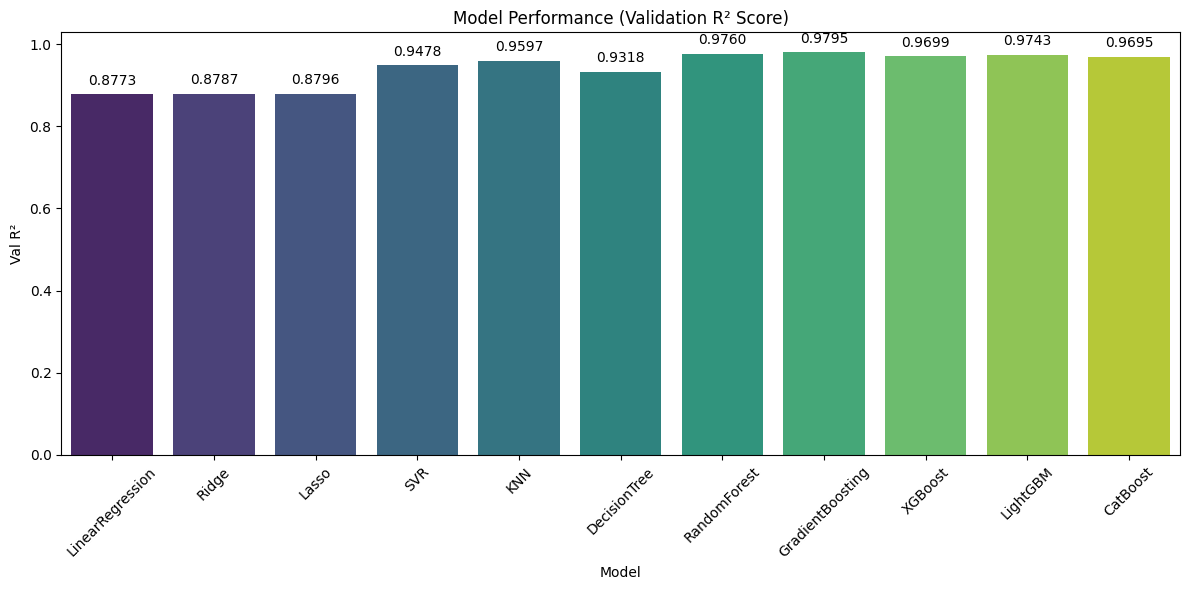

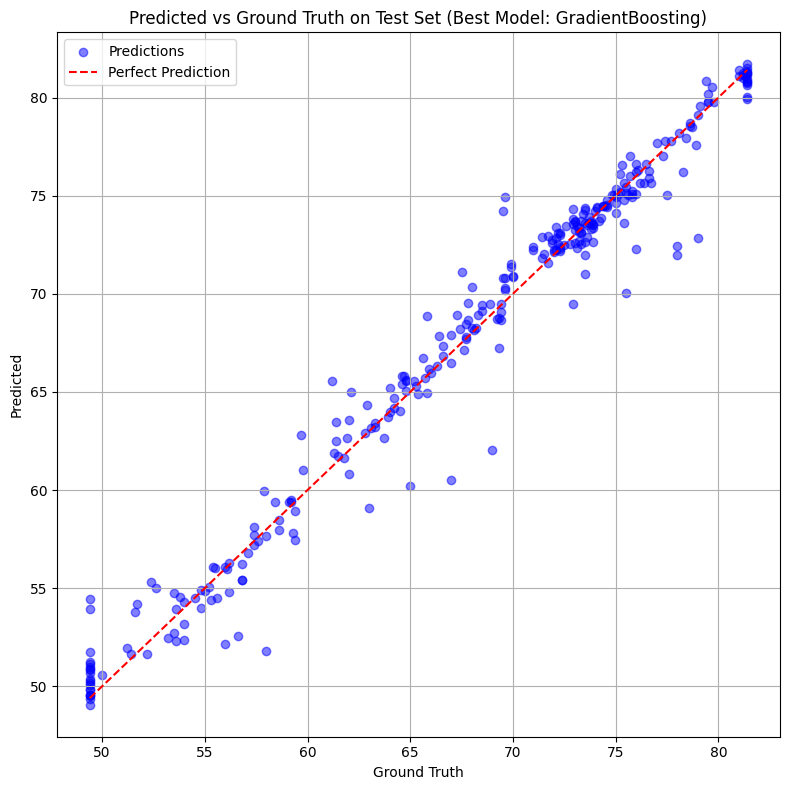

In [62]:
pipeline.visualize_results()

## Save best model

In [63]:
pipeline.save_best_model()

Best model (GradientBoosting) saved as best_model.pkl
